In [17]:
import pandapower as pp
import pandapower.networks as nw
from copy import deepcopy
import pandapower.plotting as plot
import numpy as np
import pandas as pd
import os
import numba

import julia
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

import warnings
warnings.filterwarnings('ignore')


[ Info: Julia version info


Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      "Manjaro Linux"
  uname: Linux 6.6.30-2-MANJARO #1 SMP PREEMPT_DYNAMIC Wed May  8 17:46:43 UTC 2024 x86_64 unknown
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4507 MHz   11521097 s      58287 s     440769 s   53816831 s      91437 s
       
  Memory: 62.63358688354492 GB (8085.01953125 MB free)
  Uptime: 414158.0 sec
  Load Avg:  0.67  0.53  0.63
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, goldmont)
Environment:
  HOME = /home/iboero
  PATH = /home/iboero/miniconda3/envs/proy/bin:/home/iboero/.vscode-server/cli/servers/Stable-dc96b837cf6bb4af9cd736aa3af08cf8279f7685/server/bin/remote-cli:/home/iboero/miniconda3/envs/proy/bin:/home/iboero/miniconda3/condabin:/home/iboero/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/ns

[ Info: Julia executable: /home/iboero/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
│     libpython: /home/iboero/miniconda3/envs/proy/lib/libpython3.11.so.1.0
│ Python:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
└     libpython: 


## Pruebas sobre la red creada

In [64]:
# Levantar red
net = pp.from_pickle('uy_pp_net_v11.p')
# net.ext_grid.drop(0,inplace=True)
# pp.create_ext_grid(net,4000,min_p_mw=None,max_p_mw=None,min_q_mvar=-10, max_q_mvar=10)
# pp.create_sgen(net, 90000, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=-100, max_q_mvar=0, controllable=True)
# pp.create_sgen(net, 90480, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=-67-70, max_q_mvar=-67, controllable=True)
# pp.create_sgen(net, 92100, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=-37.5-40, max_q_mvar=-37.5, controllable=True)
# pp.create_sgen(net, 92300, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=-58.5 - 60, max_q_mvar=-58.5, controllable=True)
# pp.create_sgen(net, 92500, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=-120, max_q_mvar=-60, controllable=True)
# pp.create_sgen(net, 92700, 0, 0, min_p_mw=0,max_p_mw=0, min_q_mvar=0, max_q_mvar=3*27, controllable=True)


# net.gen.vm_pu = 1.0


# Permitir solo a los generadores cambiar su potencia al resolver opf
# net.load['controllable'] = False
# net.gen['controllable'] = True


gen_p = pd.read_csv("GENP_total_pandapower.csv")
load_p = pd.read_csv("LOADP_total_pandapower.csv")

index = 12210


net.gen.p_mw = gen_p.iloc[index,1:].sort_index().values
net.load.p_mw = load_p.iloc[index,1:].sort_index().values
net.load.q_mvar = load_p.iloc[index,1:].sort_index().values * np.tan(np.arccos(0.92)) 
net.gen.max_p_mw = net.gen.p_mw 
net.gen.min_p_mw = net.gen.p_mw


# net.sgen['controllable'] = False

# net.line.c_nf_per_km /= 2
# net.line.g_us_per_km = 0

# net.gen.max_q_mvar.loc[net.gen.max_q_mvar ==0] = 0
# net.gen.min_q_mvar.loc[net.gen.min_q_mvar ==0] = 0


# net.line.c_nf_per_km /= 1

# net.min_vm_pu = 0.9
# net.max_vm_pu = 1.1
net.line.max_loading_percent = 1e3
net.trafo.max_loading_percent = 1e3


pandapowerNet-version is newer than your pandapower version. Please update pandapower `pip install --upgrade pandapower`.


In [70]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,20.224295,3.817333,-20.216713,-3.366086,0.007582,0.451246,0.023765,0.079218,1.000000,0.126297,0.995803,-1.109481,20.581403
1,32.685462,6.183493,-32.673511,-5.454149,0.011951,0.729344,0.038411,0.128038,1.000000,0.126297,0.995803,-1.109481,33.265223
2,16.015982,1.049372,-16.007042,-0.786467,0.008941,0.262905,0.018248,0.060827,1.015633,-2.070626,1.014116,-3.006477,15.803266
3,142.137597,73.378263,-142.040156,-67.667735,0.097441,5.710529,0.184904,0.616348,0.998931,-8.104129,0.982534,-9.936022,160.131972
4,150.486814,67.854674,-150.074450,-61.975072,0.412364,5.879602,0.190819,0.636063,0.998931,-8.104129,0.982534,-9.936022,165.253990
5,103.223403,46.888349,-103.167973,-43.111392,0.055430,3.776957,0.131101,0.437004,0.998562,-8.003847,0.984819,-9.754499,113.536948
6,104.723215,41.898210,-104.496103,-38.147039,0.227112,3.751171,0.130430,0.434768,0.998562,-8.003847,0.984819,-9.754499,112.956115
7,97.295182,53.782000,-97.279119,-48.179666,0.016063,5.602334,0.128355,0.427850,1.000105,-8.392250,0.976589,-10.976869,111.158768
8,97.295182,53.782000,-97.279119,-48.179666,0.016063,5.602334,0.128355,0.427850,1.000105,-8.392250,0.976589,-10.976869,111.158768
9,-26.674972,10.176355,26.691730,-9.638677,0.016759,0.537677,0.032238,0.107460,1.022609,-8.290237,1.016468,-7.263868,27.918964


In [65]:

buses_solar = [92040,92030,92020,92070,92640,92020, 92060, 92000]
buses_eolico = [92710,92091,92760,92440,92611,92700,92590,92061,92610,92580,92790,92485,92420,92620,92910,92524,92411,92490] #90160

for idx, g in net.gen.iterrows():
    if g.bus in buses_solar:
        pp.create_sgen(net, g.bus,  g.p_mw,controllable=False)
        net.gen.drop(idx,inplace=True)
    if g.bus in buses_eolico:
        pp.create_sgen(net, g.bus,  g.p_mw,controllable=False)
        net.gen.drop(idx,inplace=True)

In [66]:
print("Total Load " , net.load.p_mw.sum())

pp.runpp(net,enforce_q_lims=True)
v_org = net.res_bus.vm_pu.values
print("--- deviation from setpionts v=1 ---")
display(sum((v_org-1)**2))
display(net.res_line.pl_mw.sum())
display(net.res_line.ql_mvar.sum())

netoptv = deepcopy(net)
netoptv.bus["pm_param/setpoint_v"] = 1.0
pp.runpm_vstab(netoptv)
v_opt = netoptv.res_bus.vm_pu.values
print("--- deviation from setpionts v=1 ---")
display(sum((v_opt-1)**2)) # devition from setpoints v=0.96 p.u.
display(netoptv.res_line.pl_mw.sum())
display(netoptv.res_line.ql_mvar.sum())

netoptploss = deepcopy(net)
netoptploss.line["pm_param/target_branch"] = True  
pp.runpm_ploss(netoptploss)
v_opt_ploss = netoptploss.res_bus.vm_pu.values
print("--- deviation from setpionts v=1 ---")
display(sum((v_opt_ploss-1)**2)) # devition from setpoints v=0.96 p.u.
display(netoptploss.res_line.pl_mw.sum())
display(netoptploss.res_line.ql_mvar.sum())


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Total Load  1685.8135444499999
--- deviation from setpionts v=1 ---


0.027835960140734445

30.666367264950303

-1255.827312032121

no costs are given - overall generated power is minimized


--- deviation from setpionts v=1 ---


0.01606179983171719

30.35805520572632

-1272.1438583064048

no costs are given - overall generated power is minimized


--- deviation from setpionts v=1 ---


0.08829737542730186

29.755851168764377

-1314.548775948211

<Axes: >

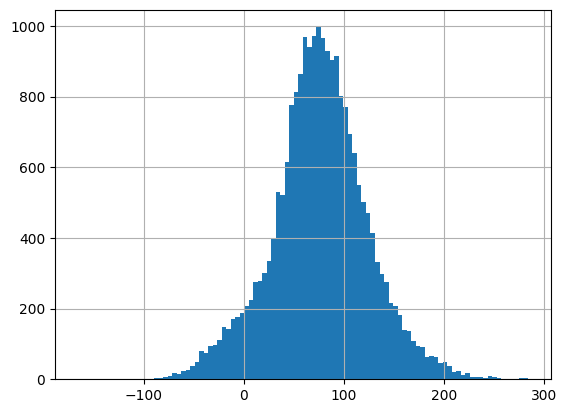

In [28]:
# Hago un histograma de la diferencia entre la potencia generada y la potencia demandada
gen_p = pd.read_csv("GENP_total_pandapower.csv")
load_p = pd.read_csv("LOADP_total_pandapower.csv")

dif = gen_p.iloc[:,1:].sum(axis=1) - load_p.iloc[:,1:].sum(axis=1)
dif.hist(bins=100)


## Generamos los datos y los guardamos en un npy

In [5]:
# net = pp.from_pickle('uy_pp_net_v6.p')
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,min_q_mvar,max_q_mvar,controllable
0,None,90000,0.000,0.00,NaN,1.0,True,wye,True,-100.0,0.0,False
1,None,90480,0.000,-67.03,NaN,1.0,True,wye,True,-70.0,0.0,False
2,None,92100,0.000,-37.56,NaN,1.0,True,wye,True,-40.0,0.0,False
3,None,92300,0.000,-58.54,NaN,1.0,True,wye,True,-60.0,0.0,False
4,None,92500,0.000,-60.00,NaN,1.0,True,wye,True,-60.0,0.0,False
5,None,92700,0.000,0.00,NaN,1.0,True,wye,True,81.0,0.0,False
6,None,92000,-0.370,0.00,NaN,1.0,True,wye,True,NaN,NaN,False
7,None,92020,0.000,0.00,NaN,1.0,True,wye,True,NaN,NaN,False
8,None,92030,0.000,0.00,NaN,1.0,True,wye,True,NaN,NaN,False
9,None,92040,45.696,0.00,NaN,1.0,True,wye,True,NaN,NaN,False


In [60]:
gen_p = pd.read_csv("GENP_total_pandapower.csv")
load_p = pd.read_csv("LOADP_total_pandapower.csv")
net = pp.from_pickle('uy_pp_net_v9.p')

net.bus["pm_param/setpoint_v"] = 1.0
# Empezar a generar datos

X = []
Y_volt = []
Y_react = []
Y_switch_shunts = []
# Dividir en 10 batches de 1000 datos
for index in range(1,1000,100):
  
  y_volt = np.zeros((len(net.bus["name"]),1))
  y_react = np.zeros((len(net.bus["name"]),1))
  y_switch_shunts  = np.zeros((len(net.bus["name"]),1))
  X_i = np.zeros((len(net.bus["name"]),3))
  print('iteracion:', index)

  net.gen.p_mw = gen_p.iloc[index,1:].sort_index().values
  net.load.p_mw = load_p.iloc[index,1:].sort_index().values
  net.load.q_mvar = load_p.iloc[index,1:].sort_index().values * np.tan(np.arccos(0.92))

  # fijamos la activa para que no cambie
  net.gen.loc[:,"max_p_mw"] = net.gen['p_mw']
  net.gen.loc[:,"min_p_mw"] = net.gen['p_mw']

  # Rellenar X
  X_i[net.bus.index.get_indexer(list(net.gen.bus.values))] += np.array([np.zeros(len(net.gen.p_mw)), np.zeros(len(net.gen.p_mw)),net.gen.p_mw.values.astype('float64')]).T
  X_i[net.bus.index.get_indexer(list(net.load.bus.values))] += np.array([net.load.p_mw.values.astype('float64'), net.load.q_mvar.values.astype('float64'), np.zeros(len(net.load.q_mvar))]).T

  # Resolver OPF
  try:
    pp.runpm_vstab(net)
    #Rellenar y
    y_volt[net.bus.index.get_indexer(list(net.gen.bus.values))] = net.res_gen.vm_pu.values.reshape(-1,1)
    y_react[net.bus.index.get_indexer(list(net.gen.bus.values))] = net.res_gen.q_mvar.values.reshape(-1,1)
    y_switch_shunts[net.bus.index.get_indexer(list(net.sgen.bus.values))] = net.res_sgen.q_mvar.values.reshape(-1,1)
    Y_volt.append(y_volt)
    Y_react.append(y_react)
    Y_switch_shunts.append(y_switch_shunts)
    X.append(X_i)
  except:
    print("no convergio")
X = np.array(X)
Y_volt = np.array(Y_volt)
Y_react = np.array(Y_react)
Y_switch_shunts = np.array(Y_switch_shunts)

np.save('./data_reactiva_uruguay/input.npy',X)
np.save('./data_reactiva_uruguay/vm_pu_opt.npy',Y_volt)
np.save('./data_reactiva_uruguay/q_mvar_opt.npy',Y_react)
np.save('./data_reactiva_uruguay/q_switch_shunt_opt.npy',Y_react)





pandapowerNet-version is newer than your pandapower version. Please update pandapower `pip install --upgrade pandapower`.
no costs are given - overall generated power is minimized


iteracion: 1


no costs are given - overall generated power is minimized


iteracion: 101


no costs are given - overall generated power is minimized


iteracion: 201


no costs are given - overall generated power is minimized


iteracion: 301


no costs are given - overall generated power is minimized


iteracion: 401


no costs are given - overall generated power is minimized


iteracion: 501


no costs are given - overall generated power is minimized


iteracion: 601


no costs are given - overall generated power is minimized


iteracion: 701


no costs are given - overall generated power is minimized


iteracion: 801


no costs are given - overall generated power is minimized


iteracion: 901


In [ ]:
# Levantar los datos


X = np.load('./data_reactiva/PlQlPg'+red+f'.npy')
Y = np.load('./data_reactiva/vpu_opt'+red+f'.npy')

In [ ]:
print(X.shape)
print(Y.shape)

(10, 30, 3)
(10, 30, 1)


In [ ]:
net = pp.networks.case30()
net.line["max_i_ka"] *= 1.1

net.load.loc[:,'p_mw'] = X[0,net.load["bus"] , 0]
net.load.loc[:,'q_mvar'] = X[0 ,net.load["bus"] , 1]
net.gen.loc[:,'p_mw'] =   X[0 ,net.gen["bus"] , 2]
net.gen.loc[:,"max_p_mw"] = net.gen['p_mw']
net.gen.loc[:,"min_p_mw"] = net.gen['p_mw']
net.line["pm_param/target_branch"] = True  

net_loss = deepcopy(net)
pp.runpm_ploss(net_loss)

net.gen.loc[:,'vm_pu'] =   Y[0 ,net.gen["bus"]]
pp.runpp(net)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



## Una vez generados los datos, los analizamos

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# List of .npy files to merge
path = './data_reactiva_uruguay_sin_eolicanisolar_v4/'

file_list_input = [f'input_{i}.0.npy' for i in range(1,24)]
file_list_q = [f'q_mvar_opt_{i}.0.npy' for i in range(1,24)]
file_list_q_shunt = [f'q_switch_shunt_opt_{i}.0.npy' for i in range(1,24)]
file_list_vm_pu = [f'vm_pu_opt_{i}.0.npy' for i in range(1,24)]

# Load the first file to initialize the merged array
input_list = []
q_list = []
q_shunt_list = []
vm_pu_list = []


# Iterate over the remaining files and concatenate them to the merged array
for idx,file in enumerate(file_list_input):
    input_list.append(np.load(path+file))
    q_list.append(np.load(path+file_list_q[idx]))
    q_shunt_list.append(np.load(path+file_list_q_shunt[idx]))
    vm_pu_list.append(np.load(path+file_list_vm_pu[idx]))

merged_input = np.concatenate(input_list, axis=0)
merged_q = np.concatenate(q_list, axis=0)
merged_q_shunt = np.concatenate(q_shunt_list, axis=0)
merged_vm_pu = np.concatenate(vm_pu_list, axis=0)

# Print shape of each array
print(merged_input.shape)
print(merged_q.shape)
print(merged_q_shunt.shape)
print(merged_vm_pu.shape)

# Save the merged array to a new .npy file
np.save(path+'input.npy', merged_input)
np.save(path+'q_mvar_opt.npy', merged_q)
np.save(path+'q_switch_shunt_opt.npy', merged_q_shunt)
np.save(path+'vm_pu_opt.npy', merged_vm_pu)



(19386, 107, 4)
(19386, 107, 1)
(19386, 107, 1)
(19386, 107, 1)


In [13]:
idx_volt

array([ 3,  6, 11, 17, 27, 37, 48, 49, 53, 71, 72, 77])

In [15]:
idx_react

array([ 3,  6, 11, 17, 27, 37, 48, 49, 53, 71, 72, 77])

In [31]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,min_p_mw,max_p_mw,min_q_mvar,max_q_mvar,controllable
0,None,90000,0.000,0.00,NaN,1.0,True,wye,True,0.0,0.0,-100.0,0.0,True
1,None,90480,0.000,-67.03,NaN,1.0,True,wye,True,0.0,0.0,-70.0,0.0,True
2,None,92100,0.000,-37.56,NaN,1.0,True,wye,True,0.0,0.0,-40.0,0.0,True
3,None,92300,0.000,-58.54,NaN,1.0,True,wye,True,0.0,0.0,-60.0,0.0,True
4,None,92500,0.000,-60.00,NaN,1.0,True,wye,True,0.0,0.0,-60.0,0.0,True
5,None,92700,0.000,0.00,NaN,1.0,True,wye,True,0.0,0.0,0.0,81.0,True
6,None,92000,-0.370,0.00,NaN,1.0,True,wye,True,NaN,NaN,NaN,NaN,False
7,None,92020,0.000,0.00,NaN,1.0,True,wye,True,NaN,NaN,NaN,NaN,False
8,None,92030,0.000,0.00,NaN,1.0,True,wye,True,NaN,NaN,NaN,NaN,False
9,None,92040,45.696,0.00,NaN,1.0,True,wye,True,NaN,NaN,NaN,NaN,False


In [ ]:
net = pp.from_pickle('uy_pp_net_v13_(sin_eolico_ni_solar).p')
# Create a map from net.bus.index to the position of the bues
bus_map = {net.bus.index[i]: i for i in range(len(net.bus))}


# That also works for a list of buses
def bus_pos(buses):
    try:
        return [bus_map[bus] for bus in buses]
    except:
        return bus_map[buses]

bus_pos(net.sgen.bus)

In [30]:
Y_switch_shunts[:,65]

array([[-59.99995848],
       [-59.99999847],
       [-59.99999913],
       ...,
       [-59.99994397],
       [-59.99995189],
       [-59.99995351]])

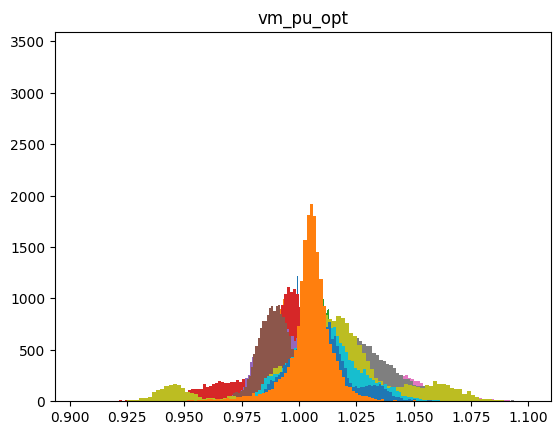

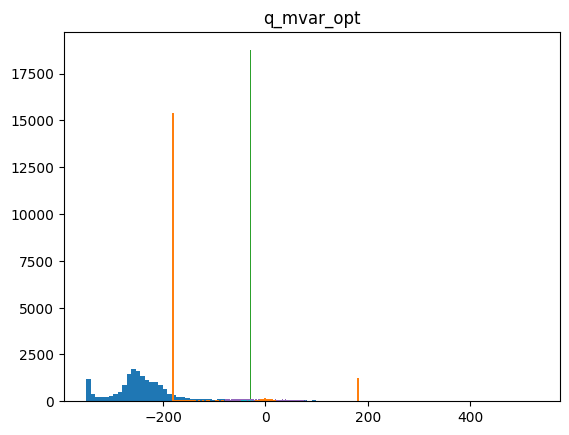

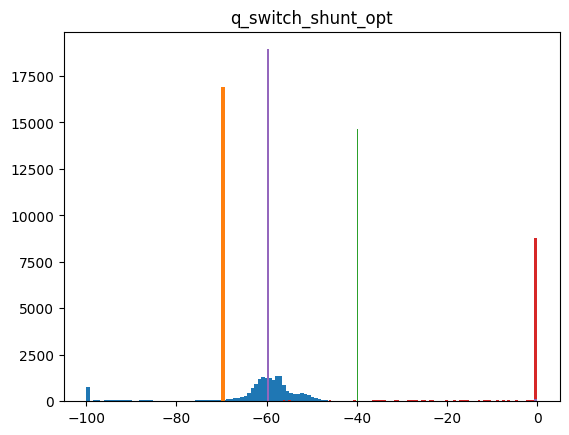

In [10]:
# Plot an histogram of the opt arrays, only for the columns that are not zero

import matplotlib.pyplot as plt
import numpy as np

# Load the data
Y_volt = np.load('./data_reactiva_uruguay_sin_eolicanisolar_v4/vm_pu_opt.npy')
Y_react = np.load('./data_reactiva_uruguay_sin_eolicanisolar_v4/q_mvar_opt.npy')
Y_switch_shunts = np.load('./data_reactiva_uruguay_sin_eolicanisolar_v4/q_switch_shunt_opt.npy')

# Get the indexes of the columns that are not zero
idx_volt = np.where(Y_volt.sum(axis=0) != 0)[0]
idx_react = np.where(Y_react.sum(axis=0) != 0)[0]
idx_switch_shunts = np.where(Y_switch_shunts.sum(axis=0) != 0)[0]

# Plot the histograms, one histogram per column, in three different figures
plt.figure()
for i in idx_volt:
    plt.hist(Y_volt[:,i], bins=100)
plt.title(f'vm_pu_opt')
plt.show()

plt.figure()
for i in idx_react:
    plt.hist(Y_react[:,i], bins=100)
plt.title(f'q_mvar_opt')
plt.show()


plt.figure()
for i in idx_switch_shunts:
    plt.hist(Y_switch_shunts[:,i], bins=100)
plt.title(f'q_switch_shunt_opt')
plt.show()

In [12]:
Y_switch_shunts.shape

(19386, 107, 1)